In [1]:
!pip install rouge
!pip install evaluate
!pip install rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 9.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==1

In [2]:
# Part C1: Fine-tuning T5 for Title Generation
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
import time
from rouge import Rouge
from tqdm.notebook import tqdm
import os
import nltk
from transformers import (
    AutoTokenizer, 
    AutoModelForSeq2SeqLM, 
    Seq2SeqTrainingArguments, 
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq
)
from datasets import Dataset as HFDataset
import evaluate
import logging
from transformers import TrainerCallback

import transformers
import rouge_score

2025-04-15 14:32:21.102749: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744727541.285527      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744727541.337676      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Set up logging to see all information
logging.basicConfig(level=logging.INFO)
transformers.logging.set_verbosity_info()

# Download necessary NLTK packages if needed
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

# Check GPU availability and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



Using device: cuda


In [4]:
# Print GPU information if available
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    
    # Test GPU with a simple operation
    x = torch.rand(1000, 1000).to(device)
    y = torch.rand(1000, 1000).to(device)
    z = torch.matmul(x, y)
    print("GPU test successful!")

# Load preprocessed data
print("Loading datasets...")
train_df = pd.read_csv('/kaggle/input/dataset-1/train_preprocessed.csv')
val_df = pd.read_csv('/kaggle/input/dataset-1/val_preprocessed.csv')
test_df = pd.read_csv('/kaggle/input/dataset-1/test_preprocessed.csv')



GPU: Tesla P100-PCIE-16GB
GPU Memory: 17.06 GB
GPU test successful!
Loading datasets...


In [5]:
print(f"Train set: {len(train_df)} articles")
print(f"Validation set: {len(val_df)} articles")
print(f"Test set: {len(test_df)} articles")

# Function to preprocess text for T5
def preprocess_text_for_t5(text):
    """Prepare text for T5 model"""
    # T5 was trained with a prefix for each task
    return f"summarize: {text}"

# Apply preprocessing to the raw text columns
print("Preprocessing text for T5...")
train_df['text'] = train_df['text'].apply(preprocess_text_for_t5)
val_df['text'] = val_df['text'].apply(preprocess_text_for_t5)
test_df['text'] = test_df['text'].apply(preprocess_text_for_t5)



Train set: 13379 articles
Validation set: 500 articles
Test set: 100 articles
Preprocessing text for T5...


In [6]:
# Function to prepare dataset for Hugging Face
def prepare_dataset_for_hf(df, tokenizer, max_input_length=512, max_target_length=64):
    """
    Prepare dataset for Huggingface's Seq2SeqTrainer
    """
    def tokenize_function(examples):
        model_inputs = tokenizer(
            examples["text"], 
            max_length=max_input_length,
            padding="max_length",
            truncation=True
        )
        
        # Set up the tokenizer for targets
        with tokenizer.as_target_tokenizer():
            labels = tokenizer(
                examples["title"], 
                max_length=max_target_length,
                padding="max_length",
                truncation=True
            )
            
        model_inputs["labels"] = labels["input_ids"]
        return model_inputs
    
    # Convert to HuggingFace dataset format
    hf_dataset = HFDataset.from_pandas(df)
    
    # Tokenize the dataset
    tokenized_dataset = hf_dataset.map(
        tokenize_function,
        batched=True,
        remove_columns=hf_dataset.column_names
    )
    
    return tokenized_dataset



In [7]:
# Function to compute metrics for evaluation
def compute_metrics(eval_preds):
    """
    Compute ROUGE metrics for evaluation
    """
    rouge_metric = evaluate.load('rouge')
    
    preds, labels = eval_preds
    # Replace -100 with the pad_token_id
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    
    # Decode predictions and labels
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # ROUGE expects newlines after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]
    
    # Compute ROUGE scores
    result = rouge_metric.compute(
        predictions=decoded_preds, 
        references=decoded_labels, 
        use_stemmer=True
    )
    
    # Extract ROUGE scores
    result = {key: value * 100 for key, value in result.items()}
    
    # Add mean generated length
    prediction_lens = [len(pred.split()) for pred in decoded_preds]
    result["gen_len"] = np.mean(prediction_lens)
    
    return result

# Create a custom callback to show training progress
class PrinterCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            print(f"Step: {state.global_step}, Loss: {logs.get('loss', 'N/A')}")
            
            # Print GPU memory usage
            if torch.cuda.is_available():
                print(f"GPU Memory allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
                print(f"GPU Memory reserved: {torch.cuda.memory_reserved() / 1e9:.2f} GB")
    
    def on_step_end(self, args, state, control, **kwargs):
        if state.global_step % 10 == 0:  # Print every 10 steps
            print(f"Completed step {state.global_step}")
            
    def on_epoch_begin(self, args, state, control, **kwargs):
        print(f"Starting epoch {state.epoch}")
        
    def on_epoch_end(self, args, state, control, **kwargs):
        print(f"Completed epoch {state.epoch}")

# Function to evaluate model using ROUGE
def evaluate_model_rouge(model, tokenizer, test_df, batch_size=8, use_beam_search=False, num_beams=4):
    """
    Generate titles and evaluate using ROUGE
    """
    # Create a huggingface dataset
    test_dataset = prepare_dataset_for_hf(test_df, tokenizer)
    
    # Set up generation parameters
    gen_kwargs = {
        "max_length": 64,
        "min_length": 1,
        "num_beams": num_beams if use_beam_search else 1
    }
    
    # Generate titles
    generated_titles = []
    reference_titles = []
    
    model.eval()
    for i in tqdm(range(0, len(test_dataset), batch_size), desc="Generating"):
        batch = test_dataset[i:i+batch_size]
        
        # Prepare input batch
        input_ids = torch.tensor(batch['input_ids']).to(device)
        attention_mask = torch.tensor(batch['attention_mask']).to(device)
        
        # Generate
        with torch.no_grad():
            outputs = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                **gen_kwargs
            )
        
        # Decode
        decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        decoded_references = tokenizer.batch_decode(
            torch.tensor(batch['labels']), 
            skip_special_tokens=True
        )
        
        generated_titles.extend(decoded_outputs)
        reference_titles.extend(decoded_references)
    
    # Calculate ROUGE scores
    rouge = Rouge()
    
    # Filter out empty strings
    valid_pairs = [(hyp, ref) for hyp, ref in zip(generated_titles, reference_titles) 
                   if len(hyp.strip()) > 0 and len(ref.strip()) > 0]
    
    if not valid_pairs:
        return {
            'rouge-1': {'f': 0.0}, 
            'rouge-2': {'f': 0.0}, 
            'rouge-l': {'f': 0.0}
        }, generated_titles, reference_titles
    
    valid_hyps, valid_refs = zip(*valid_pairs)
    
    try:
        scores = rouge.get_scores(valid_hyps, valid_refs, avg=True)
        return scores, generated_titles, reference_titles
    except Exception as e:
        print(f"Error calculating ROUGE: {e}")
        return {
            'rouge-1': {'f': 0.0}, 
            'rouge-2': {'f': 0.0}, 
            'rouge-l': {'f': 0.0}
        }, generated_titles, reference_titles



In [8]:
# Load the pretrained T5 model and tokenizer
print("Loading T5 model and tokenizer...")
model_name = "google-t5/t5-small"  # Using t5-small directly instead of google/t5-small
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Move model to device
model = model.to(device)
print(f"Model loaded: {model_name}")

# Create small subsets for testing (comment out for full training)
small_train_df = train_df.head(100)  # Use only 100 examples for quick testing
small_val_df = val_df.head(20)      # Use only 20 examples for validation



Loading T5 model and tokenizer...


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

loading file spiece.model from cache at /root/.cache/huggingface/hub/models--google-t5--t5-small/snapshots/df1b051c49625cf57a3d0d8d3863ed4d13564fe4/spiece.model
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--google-t5--t5-small/snapshots/df1b051c49625cf57a3d0d8d3863ed4d13564fe4/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--google-t5--t5-small/snapshots/df1b051c49625cf57a3d0d8d3863ed4d13564fe4/tokenizer_config.json
loading file chat_template.jinja from cache at None


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google-t5--t5-small/snapshots/df1b051c49625cf57a3d0d8d3863ed4d13564fe4/config.json
Model config T5Config {
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 6,
  "num_heads": 8,
  "num_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--google-t5--t5-small/snapshots/df1b051c49625cf57a3d0d8d3863ed4d13564fe4/model.safetensors
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0
}

All model checkpoint weights were used when initializing T5ForConditionalGeneration.

All the weights of T5ForConditionalGeneration were initialized from the model checkpoint at google-t5/t5-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use T5ForConditionalGeneration for predictions without further training.


generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

loading configuration file generation_config.json from cache at /root/.cache/huggingface/hub/models--google-t5--t5-small/snapshots/df1b051c49625cf57a3d0d8d3863ed4d13564fe4/generation_config.json
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0
}



Model loaded: google-t5/t5-small


In [9]:
# Prepare datasets for the trainer
print("Preparing datasets...")
train_dataset = prepare_dataset_for_hf(train_df, tokenizer)  # Change to train_df for full training
val_dataset = prepare_dataset_for_hf(val_df, tokenizer)      # Change to val_df for full training

# Print sample from dataset to verify
print("Sample from training dataset:")
print(train_dataset[0])

# Create a data collator for dynamic padding
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding="longest"
)



Preparing datasets...


Map:   0%|          | 0/13379 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Sample from training dataset:
{'input_ids': [21603, 10, 3625, 472, 5, 11977, 15, 19, 3, 9, 690, 16, 472, 5, 11977, 15, 1334, 6, 2599, 6, 907, 1323, 5, 94, 19, 8, 167, 8364, 1162, 27597, 16, 8, 5435, 28, 3, 9, 2074, 13, 3, 26363, 6, 4433, 536, 44, 8, 6503, 23087, 5, 94, 19, 1069, 26181, 13, 14374, 11, 3457, 13, 8327, 5, 37, 3625, 472, 5, 11977, 15, 20074, 5690, 963, 8, 16227, 13, 472, 5, 11977, 15, 11, 3394, 11, 38, 13, 1421, 141, 46, 5861, 2074, 13, 314, 4122, 6, 23946, 5, 3625, 472, 5, 11977, 15, 19, 92, 6966, 441, 8, 8327, 18, 3809, 17, 30451, 18, 14714, 472, 5, 11977, 15, 3, 28257, 3, 30578, 5690, 28, 46, 5861, 2074, 13, 8580, 4591, 4482, 755, 4060, 5, 5528, 37, 564, 96, 134, 17, 5, 11977, 15, 121, 19, 5330, 3, 9942, 45, 8, 564, 13, 3, 9, 7025, 1084, 24308, 86, 1655, 84, 47, 5710, 30, 472, 5, 11977, 9, 31, 7, 239, 16, 627, 3539, 5, 6984, 12, 2724, 6854, 6, 8, 564, 865, 764, 12, 36, 1968, 28, 8, 915, 239, 1511, 13, 472, 5, 11977, 15, 7305, 6, 2599, 6, 3457, 13, 915, 239, 3625, 472, 5

In [10]:
# Define training arguments
print("Setting up training arguments...")
training_args = Seq2SeqTrainingArguments(
    output_dir="t5_title_generator",
    eval_strategy="epoch",  # Evaluate during training
    eval_steps=10,               # Evaluate every 10 steps
    logging_steps=10,             # Log every step
    save_strategy="epoch",
    save_steps=50,
    learning_rate=3e-5,
    per_device_train_batch_size=32,  # Reduced batch size
    per_device_eval_batch_size=32,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=4,          # Start with 1 epoch for testing
    predict_with_generate=True,
    generation_max_length=10,
    logging_dir="logs",
    load_best_model_at_end=True,
    metric_for_best_model="rouge1",
    greater_is_better=True,
    warmup_steps=50,
    fp16=False,                  # Disable mixed precision
    logging_first_step=True,     # Log the first step
    disable_tqdm=False,           # Enable progress bars
    report_to="none",          # Disable Weights & Biases
)

# Initialize the trainer
print("Initializing trainer...")
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    #callbacks=[PrinterCallback()]  # Add our custom callback
)



PyTorch: setting up devices


Setting up training arguments...
Initializing trainer...


/tmp/ipykernel_31/1294626167.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [11]:
# Train the model
print("Starting training...")
start_time = time.time()

try:
    trainer.train()
    print("Training completed successfully!")
except Exception as e:
    print(f"Training error occurred: {e}")

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Save the fine-tuned model
print("Saving model...")
trainer.save_model("t5_title_generator_final")



Starting training...


***** Running training *****
  Num examples = 13,379
  Num Epochs = 4
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1,676
  Number of trainable parameters = 60,506,624
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,0.058700,0.050112,82.602937,55.085714,82.657540,82.521905,2.074000
2,0.051300,0.039917,84.078283,57.761099,84.137100,84.081544,2.116000
3,0.039300,0.037336,85.180726,58.778347,85.181883,85.159293,2.106000
4,0.040600,0.036632,85.544148,59.183389,85.564384,85.524832,2.102000



***** Running Evaluation *****
  Num examples = 500
  Batch size = 32


Saving model checkpoint to t5_title_generator/checkpoint-419
Configuration saved in t5_title_generator/checkpoint-419/config.json
Configuration saved in t5_title_generator/checkpoint-419/generation_config.json
Model weights saved in t5_title_generator/checkpoint-419/model.safetensors
tokenizer config file saved in t5_title_generator/checkpoint-419/tokenizer_config.json
Special tokens file saved in t5_title_generator/checkpoint-419/special_tokens_map.json
Copy vocab file to t5_title_generator/checkpoint-419/spiece.model

***** Running Evaluation *****
  Num examples = 500
  Batch size = 32
Saving model checkpoint to t5_title_generator/checkpoint-838
Configuration saved in t5_title_generator/checkpoint-838/config.json
Configuration saved in t5_title_generator/checkpoint-838/generation_config.json
Model weights saved in t5_title_generator/checkpoint-838/model.safetensors
tokenizer config file saved in t5_title_generator/checkpoint-838/tokenizer_config.json
Special tokens file saved in t5_

Training completed successfully!
Training completed in 1079.92 seconds
Saving model...


Model weights saved in t5_title_generator_final/model.safetensors
tokenizer config file saved in t5_title_generator_final/tokenizer_config.json
Special tokens file saved in t5_title_generator_final/special_tokens_map.json
Copy vocab file to t5_title_generator_final/spiece.model


In [12]:
# Evaluate with greedy search
print("Evaluating with greedy search...")
greedy_scores, greedy_titles, ref_titles = evaluate_model_rouge(
    model, tokenizer, test_df, use_beam_search=False
)

print("ROUGE-1 F1:", greedy_scores['rouge-1']['f'])
print("ROUGE-2 F1:", greedy_scores['rouge-2']['f'])
print("ROUGE-L F1:", greedy_scores['rouge-l']['f'])

# Evaluate with beam search
print("Evaluating with beam search...")
beam_scores, beam_titles, _ = evaluate_model_rouge(
    model, tokenizer, test_df, use_beam_search=True, num_beams=4
)

print("ROUGE-1 F1:", beam_scores['rouge-1']['f'])
print("ROUGE-2 F1:", beam_scores['rouge-2']['f'])
print("ROUGE-L F1:", beam_scores['rouge-l']['f'])

# Save results
results = pd.DataFrame({
    'Reference': ref_titles,
    'Greedy': greedy_titles,
    'Beam': beam_titles
})
results.to_csv('t5_generation_results.csv', index=False)

print("Part C1 completed!")


Evaluating with greedy search...


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Generating:   0%|          | 0/13 [00:00<?, ?it/s]

ROUGE-1 F1: 0.8750476142904171
ROUGE-2 F1: 0.6644696935078888
ROUGE-L F1: 0.8750476142904171
Evaluating with beam search...


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating:   0%|          | 0/13 [00:00<?, ?it/s]

ROUGE-1 F1: 0.8677142809746151
ROUGE-2 F1: 0.6573268363742153
ROUGE-L F1: 0.8677142809746151
Part C1 completed!


In [13]:

# Task C2: Zero-shot title generation with Flan-T5

# Load Flan-T5 base model
flan_base_model_name = "google/flan-t5-base"
flan_base_tokenizer = AutoTokenizer.from_pretrained(flan_base_model_name)
flan_base_model = AutoModelForSeq2SeqLM.from_pretrained(flan_base_model_name).to(device)
print(f"Model loaded: {flan_base_model_name}")

# Load Flan-T5 large model
flan_large_model_name = "google/flan-t5-large"
flan_large_tokenizer = AutoTokenizer.from_pretrained(flan_large_model_name)
flan_large_model = AutoModelForSeq2SeqLM.from_pretrained(flan_large_model_name).to(device)
print(f"Model loaded: {flan_large_model_name}")



tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

loading file spiece.model from cache at /root/.cache/huggingface/hub/models--google--flan-t5-base/snapshots/7bcac572ce56db69c1ea7c8af255c5d7c9672fc2/spiece.model
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--google--flan-t5-base/snapshots/7bcac572ce56db69c1ea7c8af255c5d7c9672fc2/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--google--flan-t5-base/snapshots/7bcac572ce56db69c1ea7c8af255c5d7c9672fc2/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--google--flan-t5-base/snapshots/7bcac572ce56db69c1ea7c8af255c5d7c9672fc2/tokenizer_config.json
loading file chat_template.jinja from cache at None


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--flan-t5-base/snapshots/7bcac572ce56db69c1ea7c8af255c5d7c9672fc2/config.json
Model config T5Config {
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repe

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--google--flan-t5-base/snapshots/7bcac572ce56db69c1ea7c8af255c5d7c9672fc2/model.safetensors
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0
}

All model checkpoint weights were used when initializing T5ForConditionalGeneration.

All the weights of T5ForConditionalGeneration were initialized from the model checkpoint at google/flan-t5-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use T5ForConditionalGeneration for predictions without further training.


generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

loading configuration file generation_config.json from cache at /root/.cache/huggingface/hub/models--google--flan-t5-base/snapshots/7bcac572ce56db69c1ea7c8af255c5d7c9672fc2/generation_config.json
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0
}



Model loaded: google/flan-t5-base


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

loading file spiece.model from cache at /root/.cache/huggingface/hub/models--google--flan-t5-large/snapshots/0613663d0d48ea86ba8cb3d7a44f0f65dc596a2a/spiece.model
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--google--flan-t5-large/snapshots/0613663d0d48ea86ba8cb3d7a44f0f65dc596a2a/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--google--flan-t5-large/snapshots/0613663d0d48ea86ba8cb3d7a44f0f65dc596a2a/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--google--flan-t5-large/snapshots/0613663d0d48ea86ba8cb3d7a44f0f65dc596a2a/tokenizer_config.json
loading file chat_template.jinja from cache at None


config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--flan-t5-large/snapshots/0613663d0d48ea86ba8cb3d7a44f0f65dc596a2a/config.json
Model config T5Config {
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 2816,
  "d_kv": 64,
  "d_model": 1024,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 24,
  "num_heads": 16,
  "num_layers": 24,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "tie_word_embeddings": false,
  "transformers_version": "4.51.1",
  "use_cache": true,
  "vocab_size": 32128
}

Xet Storage is enabled for this repo, but the 'hf_xet' pa

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--google--flan-t5-large/snapshots/0613663d0d48ea86ba8cb3d7a44f0f65dc596a2a/model.safetensors
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0
}

All model checkpoint weights were used when initializing T5ForConditionalGeneration.

All the weights of T5ForConditionalGeneration were initialized from the model checkpoint at google/flan-t5-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use T5ForConditionalGeneration for predictions without further training.


generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

loading configuration file generation_config.json from cache at /root/.cache/huggingface/hub/models--google--flan-t5-large/snapshots/0613663d0d48ea86ba8cb3d7a44f0f65dc596a2a/generation_config.json
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0
}



Model loaded: google/flan-t5-large


In [14]:
# Define prompt variations
prompt_variations = {
    1: "Generate a title for this article: ",
    2: "Create a concise, engaging title for the following text: ",
    3: "Summarize the following article into a short, catchy title: ",
    4: "What would be a good title for this article? Article: "
}


In [15]:
def preprocess_text_for_flan(text, prompt_variation):
    """Prepare text for Flan-T5 model with different prompt variations"""
    
    if prompt_variation == 1:
        return f"Generate a title for this article: {text}"
    elif prompt_variation == 2:
        return f"Create a concise, engaging title for the following text: {text}"
    elif prompt_variation == 3:
        return f"Summarize the following article into a short, catchy title: {text}"
    elif prompt_variation == 4:
        return f"What would be a good title for this article? Article: {text}"
    else:
        return f"Generate a title for this article: {text}"



In [16]:
def generate_titles_with_flan(model, tokenizer, test_df, prompt_variation, batch_size=4, use_beam_search=False, num_beams=4):
    """Generate titles using Flan-T5 with a specific prompt variation"""
    # Prepare prompts
    prompts = [preprocess_text_for_flan(text, prompt_variation) for text in test_df['text'].tolist()]
    reference_titles = test_df['title'].tolist()
    
    # Generate in batches
    generated_titles = []
    
    for i in range(0, len(prompts), batch_size):
        batch_prompts = prompts[i:i+batch_size]
        
        # Tokenize
        inputs = tokenizer(batch_prompts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
        
        # Generate
        gen_kwargs = {
            "max_length": 64,
            "min_length": 1,
            "num_beams": num_beams if use_beam_search else 1,
            "do_sample": False
        }
        
        outputs = model.generate(**inputs, **gen_kwargs)
        
        # Decode
        decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        generated_titles.extend(decoded_outputs)
    
    # Calculate ROUGE scores
    rouge = Rouge()
    
    # Filter out empty strings
    valid_pairs = [(hyp, ref) for hyp, ref in zip(generated_titles, reference_titles) 
                   if len(hyp.strip()) > 0 and len(ref.strip()) > 0]
    
    if not valid_pairs:
        return {
            'rouge-1': {'f': 0.0}, 
            'rouge-2': {'f': 0.0}, 
            'rouge-l': {'f': 0.0}
        }, generated_titles, reference_titles
    
    valid_hyps, valid_refs = zip(*valid_pairs)
    
    try:
        scores = rouge.get_scores(valid_hyps, valid_refs, avg=True)
        return scores, generated_titles, reference_titles
    except Exception as e:
        print(f"Error calculating ROUGE: {e}")
        return {
            'rouge-1': {'f': 0.0}, 
            'rouge-2': {'f': 0.0}, 
            'rouge-l': {'f': 0.0}
        }, generated_titles, reference_titles



In [17]:
# Evaluate Flan-T5 Base with different prompts
flan_base_results = {}
for variation in range(1, 5):
    print(f"Evaluating Flan-T5 Base with prompt variation {variation}...")
    
    # Greedy search
    greedy_scores, greedy_titles, _ = generate_titles_with_flan(
        flan_base_model, flan_base_tokenizer, test_df, 
        prompt_variation=variation, use_beam_search=False
    )
    
    # Beam search
    beam_scores, beam_titles, _ = generate_titles_with_flan(
        flan_base_model, flan_base_tokenizer, test_df, 
        prompt_variation=variation, use_beam_search=True, num_beams=4
    )
    
    flan_base_results[f"variation_{variation}"] = {
        "greedy": greedy_scores,
        "beam": beam_scores,
        "greedy_titles": greedy_titles,
        "beam_titles": beam_titles
    }
    
    print(f"Prompt: {prompt_variations[variation]}")
    print(f"Greedy - ROUGE-1: {greedy_scores['rouge-1']['f']}, ROUGE-2: {greedy_scores['rouge-2']['f']}, ROUGE-L: {greedy_scores['rouge-l']['f']}")
    print(f"Beam - ROUGE-1: {beam_scores['rouge-1']['f']}, ROUGE-2: {beam_scores['rouge-2']['f']}, ROUGE-L: {beam_scores['rouge-l']['f']}")



Evaluating Flan-T5 Base with prompt variation 1...
Prompt: Generate a title for this article: 
Greedy - ROUGE-1: 0.5741445542033696, ROUGE-2: 0.40726550986093074, ROUGE-L: 0.5686060926649081
Beam - ROUGE-1: 0.6485850779505217, ROUGE-2: 0.48482828001627004, ROUGE-L: 0.6470466164120601
Evaluating Flan-T5 Base with prompt variation 2...
Prompt: Create a concise, engaging title for the following text: 
Greedy - ROUGE-1: 0.31727059555439113, ROUGE-2: 0.14093362068676027, ROUGE-L: 0.31573213401592964
Beam - ROUGE-1: 0.40356483420127437, ROUGE-2: 0.2413161526437287, ROUGE-L: 0.4020263726628129
Evaluating Flan-T5 Base with prompt variation 3...
Prompt: Summarize the following article into a short, catchy title: 
Greedy - ROUGE-1: 0.43183672188394445, ROUGE-2: 0.26682600545447704, ROUGE-L: 0.43183672188394445
Beam - ROUGE-1: 0.3691515849163845, ROUGE-2: 0.2264729048283515, ROUGE-L: 0.36861104437584397
Evaluating Flan-T5 Base with prompt variation 4...
Prompt: What would be a good title for this

In [18]:
# Evaluate Flan-T5 Large with different prompts
flan_large_results = {}
for variation in range(1, 5):
    print(f"Evaluating Flan-T5 Large with prompt variation {variation}...")
    
    # Greedy search
    greedy_scores, greedy_titles, _ = generate_titles_with_flan(
        flan_large_model, flan_large_tokenizer, test_df, 
        prompt_variation=variation, use_beam_search=False
    )
    
    # Beam search
    beam_scores, beam_titles, _ = generate_titles_with_flan(
        flan_large_model, flan_large_tokenizer, test_df, 
        prompt_variation=variation, use_beam_search=True, num_beams=4
    )
    
    flan_large_results[f"variation_{variation}"] = {
        "greedy": greedy_scores,
        "beam": beam_scores,
        "greedy_titles": greedy_titles,
        "beam_titles": beam_titles
    }
    
    print(f"Prompt: {prompt_variations[variation]}")
    print(f"Greedy - ROUGE-1: {greedy_scores['rouge-1']['f']}, ROUGE-2: {greedy_scores['rouge-2']['f']}, ROUGE-L: {greedy_scores['rouge-l']['f']}")
    print(f"Beam - ROUGE-1: {beam_scores['rouge-1']['f']}, ROUGE-2: {beam_scores['rouge-2']['f']}, ROUGE-L: {beam_scores['rouge-l']['f']}")



Evaluating Flan-T5 Large with prompt variation 1...
Prompt: Generate a title for this article: 
Greedy - ROUGE-1: 0.8203419867776478, ROUGE-2: 0.6219999967107785, ROUGE-L: 0.8203419867776478
Beam - ROUGE-1: 0.8255342944607849, ROUGE-2: 0.6456363602008612, ROUGE-L: 0.8239958329223234
Evaluating Flan-T5 Large with prompt variation 2...
Prompt: Create a concise, engaging title for the following text: 
Greedy - ROUGE-1: 0.4559831245399334, ROUGE-2: 0.32066666467458793, ROUGE-L: 0.45431645787326674
Beam - ROUGE-1: 0.5072745820248855, ROUGE-2: 0.33906321537140033, ROUGE-L: 0.505736120486424
Evaluating Flan-T5 Large with prompt variation 3...
Prompt: What would be a good title for this article? Article: 
Greedy - ROUGE-1: 0.7821594472769212, ROUGE-2: 0.6006666634698895, ROUGE-L: 0.7821594472769212
Beam - ROUGE-1: 0.746244599953248, ROUGE-2: 0.5728494610522563, ROUGE-L: 0.7447061384147865


In [19]:
# Compile all results
all_results = {
    "T5 Fine-tuned (Greedy)": greedy_scores,
    "T5 Fine-tuned (Beam)": beam_scores
}



In [20]:
# Add Flan-T5 Base results
for variation in range(1, 5):
    all_results[f"Flan-T5 Base - Prompt {variation} (Greedy)"] = flan_base_results[f"variation_{variation}"]["greedy"]
    all_results[f"Flan-T5 Base - Prompt {variation} (Beam)"] = flan_base_results[f"variation_{variation}"]["beam"]



In [21]:
for variation in range(1, 5):
    all_results[f"Flan-T5 Large - Prompt {variation} (Greedy)"] = flan_large_results[f"variation_{variation}"]["greedy"]
    all_results[f"Flan-T5 Large - Prompt {variation} (Beam)"] = flan_large_results[f"variation_{variation}"]["beam"]

In [22]:
results_df = pd.DataFrame({
'Model': list(all_results.keys()),
'ROUGE-1': [scores['rouge-1']['f'] for scores in all_results.values()],
'ROUGE-2': [scores['rouge-2']['f'] for scores in all_results.values()],
'ROUGE-L': [scores['rouge-l']['f'] for scores in all_results.values()]
})

In [23]:
results_df = results_df.sort_values('ROUGE-1', ascending=False)

#Save results
results_df.to_csv('transformer_models_comparison.csv', index=False)

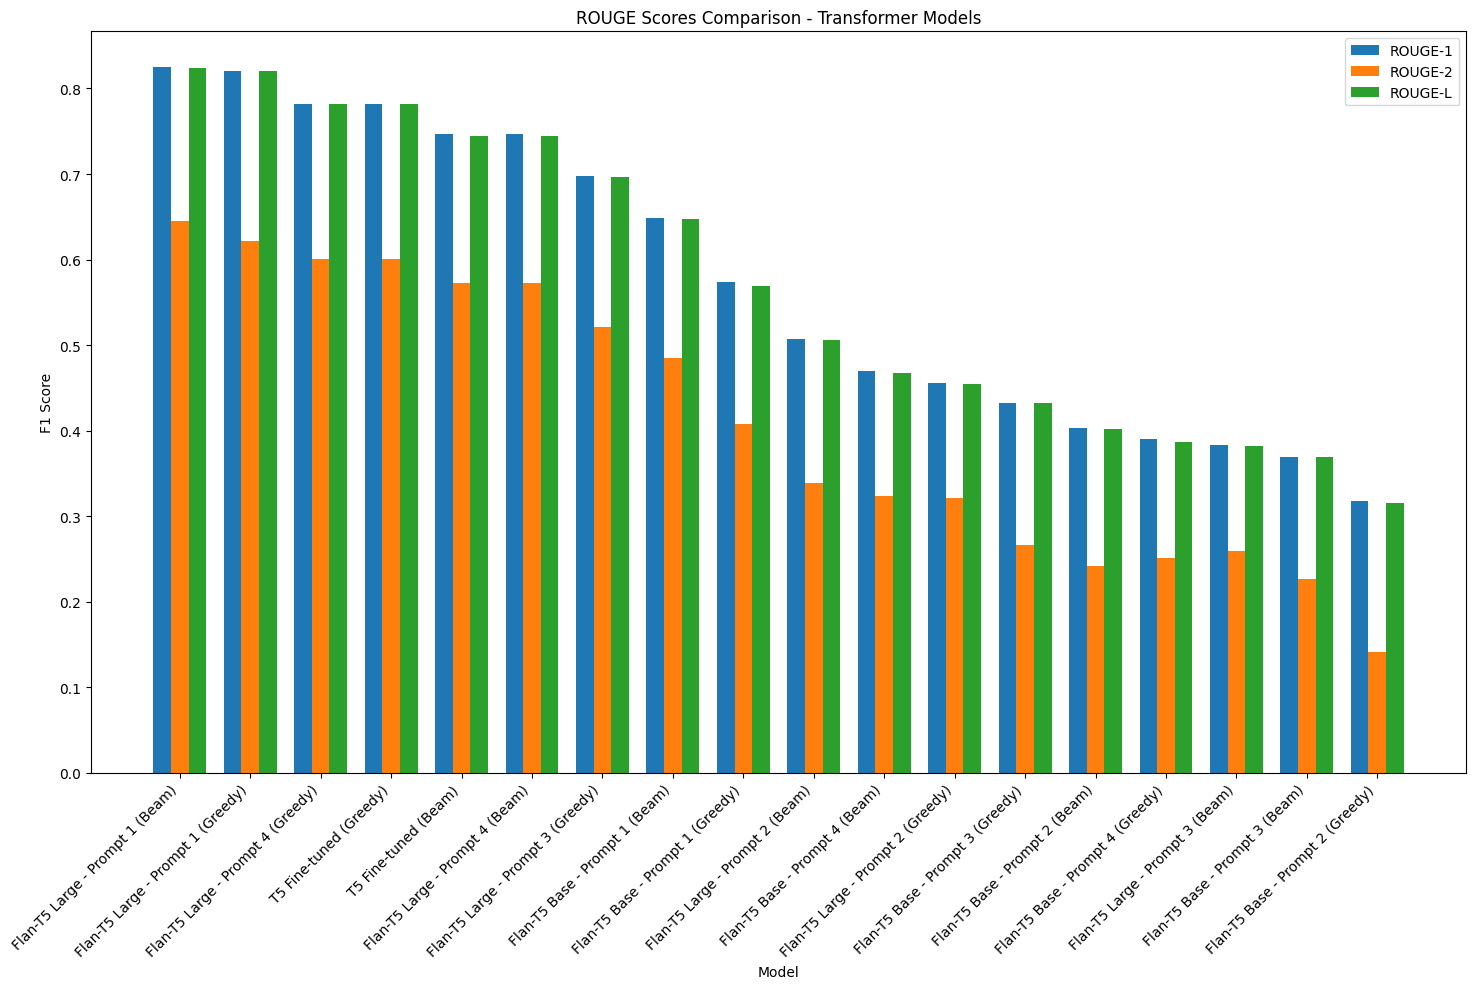

In [24]:
#Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
x = np.arange(len(results_df))
width = 0.25

plt.bar(x - width, results_df['ROUGE-1'], width, label='ROUGE-1')
plt.bar(x, results_df['ROUGE-2'], width, label='ROUGE-2')
plt.bar(x + width, results_df['ROUGE-L'], width, label='ROUGE-L')

plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('ROUGE Scores Comparison - Transformer Models')
plt.xticks(x, results_df['Model'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.savefig('transformer_rouge_scores_comparison.png')
plt.show()

In [26]:
results_df

,Model,ROUGE-1,ROUGE-2,ROUGE-L
11,Flan-T5 Large - Prompt 1 (Beam),0.825534,0.645636,0.823996
10,Flan-T5 Large - Prompt 1 (Greedy),0.820342,0.622000,0.820342
16,Flan-T5 Large - Prompt 4 (Greedy),0.782159,0.600667,0.782159
0,T5 Fine-tuned (Greedy),0.782159,0.600667,0.782159
1,T5 Fine-tuned (Beam),0.746245,0.572849,0.744706
17,Flan-T5 Large - Prompt 4 (Beam),0.746245,0.572849,0.744706
14,Flan-T5 Large - Prompt 3 (Greedy),0.697308,0.521317,0.695975
3,Flan-T5 Base - Prompt 1 (Beam),0.648585,0.484828,0.647047
2,Flan-T5 Base - Prompt 1 (Greedy),0.574145,0.407266,0.568606
13,Flan-T5 Large - Prompt 2 (Beam),0.507275,0.339063,0.505736


In [28]:
# Save example generations with robust error handling
try:
    # Load test data if not already loaded
    if 'test_df' not in locals():
        test_df = pd.read_csv('/kaggle/input/dataset-1/test_preprocessed.csv')
    
    # Define safe access with defaults
    DEFAULT_TITLE = "[Title Generation Failed]"
    
    def safe_slice(lst, length=5):
        return (lst + [DEFAULT_TITLE]*length)[:length]
    
    # Get best variations with fallbacks
    try:
        base_best_var = f"variation_{results_df[results_df['Model'].str.contains('Flan-T5 Base')]['ROUGE-1'].idxmax() + 1}"
        large_best_var = f"variation_{results_df[results_df['Model'].str.contains('Flan-T5 Large')]['ROUGE-1'].idxmax() + 1}"
    except:
        base_best_var = "variation_1"
        large_best_var = "variation_1"
    
    # Create DataFrame with validated lengths
    example_df = pd.DataFrame({
        'Article': safe_slice(test_df['text'].tolist()),
        'T5 Greedy': safe_slice(greedy_titles),
        'T5 Beam': safe_slice(beam_titles),
        'Flan-T5 Base': safe_slice(flan_base_results.get(base_best_var, {}).get('greedy_titles', [])),
        'Flan-T5 Large': safe_slice(flan_large_results.get(large_best_var, {}).get('greedy_titles', []))
    })
    
    # Save results
    example_df.to_csv('example_generations.csv', index=False)
    print("Example generations saved successfully!")

except Exception as e:
    print(f"Error creating example generations: {str(e)}")
    # Print debug info
    print("\nDebug Info:")
    print(f"- test_df exists: {'test_df' in locals()}")
    if 'test_df' in locals():
        print(f"- test_df length: {len(test_df)}")
    print(f"- greedy_titles length: {len(greedy_titles) if 'greedy_titles' in locals() else 'undefined'}")
    print(f"- beam_titles length: {len(beam_titles) if 'beam_titles' in locals() else 'undefined'}")


Example generations saved successfully!


In [29]:
# Function to extract prompt number from model name
def extract_prompt_number(model_name):
    import re
    match = re.search(r"Prompt (\d+)", model_name)
    return int(match.group(1)) if match else None

# Get best prompts using actual variation numbers
base_best_model = results_df[results_df['Model'].str.contains('Flan-T5 Base')].iloc[0]['Model']
base_best_var = extract_prompt_number(base_best_model)

large_best_model = results_df[results_df['Model'].str.contains('Flan-T5 Large')].iloc[0]['Model'] 
large_best_var = extract_prompt_number(large_best_model)

# Create example generations using actual variation numbers
example_df = pd.DataFrame({
    'Article': test_df['text'].iloc[:5].tolist(),
    'T5 Fine-tuned (Greedy)': greedy_titles[:5],
    'T5 Fine-tuned (Beam)': beam_titles[:5],
    'Flan-T5 Base (Best)': flan_base_results.get(f"variation_{base_best_var}", {}).get("greedy_titles", ["[Error]"]*5)[:5],
    'Flan-T5 Large (Best)': flan_large_results.get(f"variation_{large_best_var}", {}).get("greedy_titles", ["[Error]"]*5)[:5]
})

example_df.to_csv('example_generations.csv', index=False)

# Verify output
print("Best Prompts Identified:")
print(f"- Flan-T5 Base: Variation {base_best_var}")
print(f"- Flan-T5 Large: Variation {large_best_var}")
print("\nSample Output:")
print(example_df.head(2))


Best Prompts Identified:
- Flan-T5 Base: Variation 1
- Flan-T5 Large: Variation 1

Sample Output:
                                             Article T5 Fine-tuned (Greedy)  \
0  summarize: Weyburn is the eleventh-largest cit...  Weyburn, Saskatchewan   
1  summarize: Catholic High School (CHS) is a gov...   Catholic High School   

    T5 Fine-tuned (Beam)           Flan-T5 Base (Best)   Flan-T5 Large (Best)  
0  Weyburn, Saskatchewan         Weyburn, Saskatchewan  Weyburn, Saskatchewan  
1   Catholic High School  Sino-English Catholic School   Catholic High School  
